In [1]:
from google.colab import drive

drive.mount('/content/drive')

path = '/content/drive/My Drive/Weights_folder/PINN_dim2'


Mounted at /content/drive


In [2]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Set data type
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)


S_range = [0, 160]
t_range = [0, 1]
K= 40
sigma = np.array([[0.1, 0.0], [-0.1, 0.1732051]])  # 2x2 matrix for sigma
r =0.05
T = 1

# Define the exercise function
gs = lambda x: np.fmax(x-K, 0)

# Define residual of the PDE
# def fun_r(t, x, u, u_t, u_x0, u_x1, u_xx00, u_xx10, u_xx01, u_xx11):
#     u_xx = [[u_xx00, u_xx10], [u_xx01, u_xx11]]
#     sigma_sq = tf.linalg.matmul(sigma, tf.transpose(sigma))
#     term1 = r * (x[0] * u_x0 + x[1] * u_x1)
#     term2 = 0.0
#     for i in range(len(x)):
#         for j in range(len(x)):
#             term2 += 0.5 * sigma_sq[i, j] * x[i] * x[j] * u_xx[i][j]
#     return u_t + term1 + term2 - r * u
def fun_r(t, x, u, u_t, u_x0, u_x1, u_xx00, u_xx11):
    u_xx = [u_xx00, u_xx11]
    # Calculer les carrés des éléments de la matrice
    carres = np.square(sigma)

    # Somme des carrés le long des lignes
    sigmas_sq = np.sum(carres, axis=1)

    term1 = r * (x[0] * u_x0 + x[1] * u_x1)
    term2 = 0.0
    for i in range(len(x)):
      term2 += 0.5 * sigmas_sq[i] * x[i] * x[i] * u_xx[i]
    return u_t + term1 + term2 - r * u



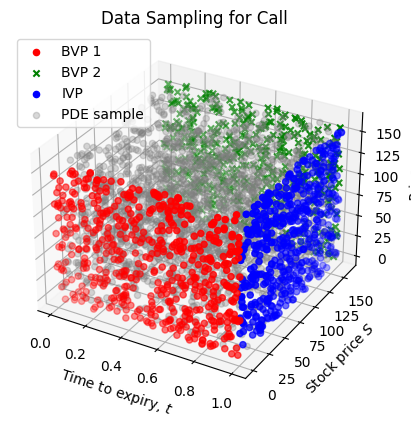

121.47222329116713


In [3]:

#pde samples
def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        np.random.uniform(*S_range, (n, 1)),
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y = np.zeros((n, 1)) #price
    return X, y

#initial values
def get_ivp_data(n):
    X = np.concatenate([np.ones((n, 1)),
                        np.random.uniform(*S_range, (n, 1)),
                    np.random.uniform(*S_range, (n, 1))], axis=1)
    y = gs(0.5*(X[:,1] + X[:,2])).reshape(-1, 1)

    return X, y



#boundary values
def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1)),
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y1 = np.zeros((n, 1))

    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[-1] * np.ones((n, 1)),
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)

    return X1, y1, X2, y2

# Set number of data points
N_0 = 500
N_b = 500
N_r = 2000

# Generate data
bvp_x1, bvp_y1, bvp_x2, bvp_y2 = get_bvp_data(N_b)
ivp_x1, ivp_y1 = get_ivp_data(N_0)
diff_x1, diff_y1 = get_diff_data(N_r)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plots
ax.scatter(bvp_x1[:, 0], bvp_x1[:, 1], bvp_x1[:, 2], label="BVP 1", color="red", marker="o")
ax.scatter(bvp_x2[:, 0], bvp_x2[:, 1], bvp_x2[:, 2], label="BVP 2", color="green", marker="x")
# Plot IVP data
ax.scatter(ivp_x1[:, 0], ivp_x1[:, 1], ivp_x1[:, 2], label="IVP", color="blue")
ax.scatter(diff_x1[:, 0], diff_x1[:, 1], diff_x1[:, 2], label="PDE sample", color="grey", alpha=0.3)

# Labeling
ax.set_xlabel('Time to expiry, $t$')
ax.set_ylabel('Stock price $S$')
ax.set_zlabel('Price')
ax.set_title('Data Sampling for Call')
ax.legend()

plt.show()

X_data = [ivp_x1, bvp_x1,bvp_x2]
u_data = [ivp_y1, bvp_y1,bvp_y2]
X_r =diff_x1


X_data = tf.convert_to_tensor([tf.convert_to_tensor(data, dtype=tf.float64) for data in X_data])
u_data = tf.convert_to_tensor([tf.convert_to_tensor(data, dtype=tf.float64) for data in u_data])
X_r = tf.convert_to_tensor( X_r)

print(S_range[-1] - K*np.exp(-r*(T-0.25)))

In [4]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model



def init_model2(num_hidden_layers=8, num_neurons_per_layer=100):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is three-dimensional (time + 2 spatial dimensions)
    model.add(tf.keras.Input(3))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    #model.add(scaling_layer)

    # Append first hidden layer
    model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('leaky_relu'),
            kernel_initializer='glorot_normal'))

    # Append remaining hidden layers
    for _ in range(num_hidden_layers - 1):
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model


In [5]:

t, x = X_r[:, 0:1], X_r[:,1:3]
print(t[:,0], x[:,0])

tf.Tensor([0.97554474 0.21146236 0.55448298 ... 0.48710244 0.87582825 0.90635695], shape=(2000,), dtype=float64) tf.Tensor(
[152.52247237  63.31086213 142.89938939 ...  79.10566266 157.93634462
  32.87270892], shape=(2000,), dtype=float64)


In [6]:
def get_r(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x0, x1 = X_r[:, 0:1], X_r[:,1:2], X_r[:,2:3]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x0)
        tape.watch(x1)

        # Determine residual
        u = model(tf.stack([t[:,0], x0[:,0], x1[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x0 = tape.gradient(u, x0)
        u_x1 = tape.gradient(u, x1)

    u_t = tape.gradient(u, t)
    u_xx00 = tape.gradient(u_x0, x0)
    u_xx11 = tape.gradient(u_x1, x1)
    # u_xx01 = tape.gradient(u_x1, x0)
    # u_xx10 = tape.gradient(u_x0, x1)

    del tape

    return fun_r(t, [x0,x1], u, u_t, u_x0, u_x1, u_xx00, u_xx11)

def compute_loss(model, X_r, X_data, u_data):

    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add phi^0 and phi^b to the loss
    # for i in range(len(X_data)):                            # Youssef commented this loop and replaced it with the two next lines
    #     u_pred = model(X_data[i])
    #     loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    u_pred = model(X_data[0])
    loss += tf.reduce_mean(tf.square(u_data[0] - u_pred))

    return loss

def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g


In [7]:
# Initialize model aka u_\theta
model = init_model2()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=7e-5)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               400       
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [9]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
N = 0
hist = []

# Start timer
t0 = time()

while True:

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())
    if (loss<1.8 * 10**(-2)):
      print(N)
      break

    # Output current loss after 50 iterates
    if N%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(N,loss))
    N+=1

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 2.72907253e+03
It 00050: loss = 2.24905699e+03
It 00100: loss = 2.00315808e+03
It 00150: loss = 1.86334457e+03
It 00200: loss = 1.77730762e+03
It 00250: loss = 1.71994970e+03
It 00300: loss = 1.67790269e+03
It 00350: loss = 1.64238871e+03
It 00400: loss = 1.61043152e+03
It 00450: loss = 1.58244341e+03
It 00500: loss = 1.55709016e+03
It 00550: loss = 1.53257217e+03
It 00600: loss = 1.50783245e+03
It 00650: loss = 1.46651705e+03
It 00700: loss = 1.43757144e+03
It 00750: loss = 1.41395730e+03
It 00800: loss = 1.39196625e+03
It 00850: loss = 1.37096617e+03
It 00900: loss = 1.35074772e+03
It 00950: loss = 1.33113935e+03
It 01000: loss = 1.31207030e+03
It 01050: loss = 1.29348503e+03
It 01100: loss = 1.27526680e+03
It 01150: loss = 1.25744548e+03
It 01200: loss = 1.23997215e+03
It 01250: loss = 1.22284933e+03
It 01300: loss = 1.20602783e+03
It 01350: loss = 1.18951126e+03
It 01400: loss = 1.17326941e+03
It 01450: loss = 1.15730937e+03
It 01500: loss = 1.14159469e+03
It 01550

KeyboardInterrupt: 

In [10]:
#save errors in a file
with open('errorPINNAVECcondLimite.txt', 'w') as file:
    for error in hist[:65614]:
        file.write(f"{error}\n")

In [11]:
#Save the model
model.save_weights(path)


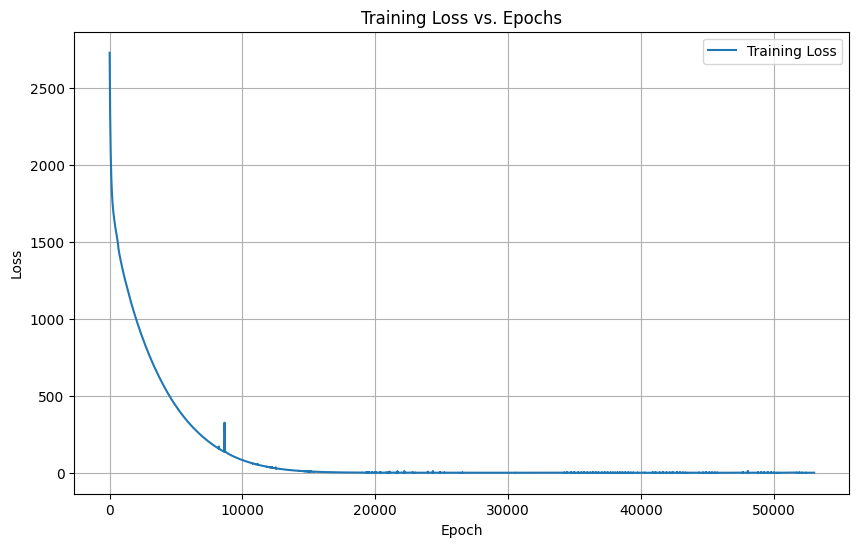

In [12]:
# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(hist[:65614], label='Training Loss')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define your ss, tt, and pred data
ss = np.linspace(0, 160, 100)
tt = np.array([0] * ss.shape[0])
pred = np.zeros((len(ss), len(ss)))  # Initialize pred as a 2D array of zeros
for i, s1 in enumerate(ss):
    for j, s2 in enumerate(ss):
        pred[i, j] = model(np.array([[tt[i], s1, s2]])).numpy().flatten()[0]



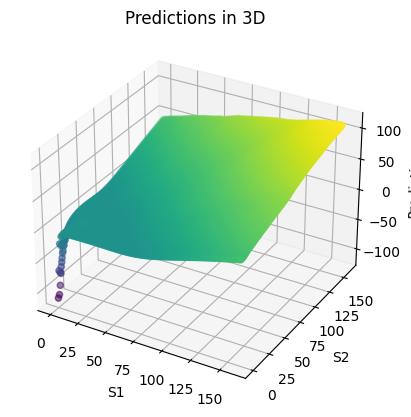

In [14]:
# Convert pred to a numpy array
pred = np.array(pred)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Flatten ss and tt arrays to match the shape of pred
ss1_flat, ss2_flat = np.meshgrid(ss, ss)
ss1_flat = ss1_flat.flatten()
ss2_flat = ss2_flat.flatten()

# Plot predictions
ax.scatter(ss1_flat, ss2_flat, pred.flatten(), c=pred.flatten(), cmap='viridis')

# Labeling
ax.set_xlabel('S1')
ax.set_ylabel('S2')
ax.set_zlabel('Prediction')
ax.set_title('Predictions in 3D')

plt.show()


In [ ]:
pred